This file is basically the same as random_perturbations_logdi except generalized to multiple p's. 

In [4]:
import pandas as pd
import numpy as np
import math
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import model_bias_analysis
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # comment this out if higher resolution is not needed

In [5]:
# Remember to always check that these files look the way you want before you run this! see data-di-with-gay to regenerate

joined_tox = pd.read_csv('joined_tox.csv')
train_comments = pd.read_csv('train_comments.csv')
test_comments = pd.read_csv('test_comments.csv')
madlibs_terms = ['gay', 'homosexual', 'straight', 'black', 'white', 'american', 'jewish', 'old']

In [6]:
# Generates perturbations
# Basically, creates num_perturbations number of arrays. 
# Each array is the length of the train_comments
# Each item in the array is 0/1 and is PROBABILITY_FLIP flipped from the true value of binary toxicity 

def generate_perturbation_on_training(train_comments, num_perturbations, probability_flip):
    print("probflip", probability_flip)
    
    list_perturbation = []
    rand = []
    tox_tmp = []
    num_flipped = 0
    
    length = len(train_comments.binary_tox.values)
    for j in range(num_perturbations):
        rand = np.random.random(length) # generate a random number (between 0 and 1) for each comment
        tox_tmp = np.copy(train_comments.binary_tox.values) # np.copy(tox_np)
        for i in range(length):
            if rand[i] >= probability_flip: # if random number is greater than 0.5, replace value in array with a random integer from [0, 1]
                tox_tmp[i] = np.random.randint(2)
                num_flipped += 1
        list_perturbation.append(tox_tmp)

    # each item in list_perturbation is a list of 0s and 1s that correspond to the new binary_tox of each variable
    print(num_flipped)
    return list_perturbation

In [7]:
def train_and_predict(train_comments, list_perturbations_training, test_comments, NUM_PERTURBATIONS):

    # This trains a classifier on n different perturbed datsets
    d={}
    for x in range(NUM_PERTURBATIONS):
        d["clf{0}".format(x)] = Pipeline([
            ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
            ('tfidf', TfidfTransformer(norm = 'l2')),
            ('clf', LogisticRegression()),
        ])
        d["clf{0}".format(x)] = d["clf{0}".format(x)].\
                                    fit(train_comments['comment'], list_perturbations_training[x])
        d["auc{0}".format(x)] = roc_auc_score(test_comments['binary_tox'], \
                                    d["clf{0}".format(x)].predict_proba(test_comments['comment'])[:, 1])
        print('x Test ROC AUC: %.5f' %d["auc{0}".format(x)])
        
    # Once a classifier is trained, this goes to the test data and creates predictions on test data
    perturbed_predictions = [] # list, each item is array of predictions. element 0 is 0th perturbation and 
    # predictions based on that.
    # each item in the array is a column that indicates 0/1 for predicted not-toxic/toxic

    for i in range(NUM_PERTURBATIONS):
        perturbed_predictions.append(d["clf{0}".format(i)].predict(test_comments['comment']))
                                                                                 
    return perturbed_predictions

In [8]:
def logDI(df, labels_col, terms):
    # labels_col is true/false of the comment being classified as toxic. ('binary_tox' I believe)
    # terms should be the array of top 8 terms
    
    logDI_arr = np.empty(((len(terms)), len(terms)))
    
    for i in range(len(terms)):
        for j in range(len(terms)):
            # print("******", i)
            logDI_arr[i, j] =  (math.log(len(df[(df[terms[i]]==True) & (df[labels_col]==True)]) / len(df[df[terms[i]]==True])) \
                            - math.log(len(df[(df[terms[j]]==True) & (df[labels_col]==True)]) / len(df[df[terms[j]]==True])))**2
                
    logDI = logDI_arr.sum() / 2
    return logDI

In [9]:
def find_avg_logDI(list_perturbations, df, madlibs_terms):
    # find logDI for each item in list_perturbations_training
    logs = []
    for i in range(len(list_perturbations)):
        namecol = 'perturbation' + str(i)
        df[namecol] = list_perturbations[i]
        logs.append(logDI(df, namecol, madlibs_terms))
    return logs

In [10]:
p_vals = [0.20, 0.3, 0.40, 0.50, 0.60, 0.7, 0.80]
logs_training = [] # means
logs_test = [] # means
list_training = [] # perturbations
list_test = [] # perturbations

ys_all_logs = [] # corresponds to below
all_logs_training = [] # not means
all_logs_test = [] # not means
logs_training_list = [] # temp
logs_test_list = [] # temp

NUM_PERTURBATIONS = 5 # This is the number of perturbations we're doing on EACH p-val below
for i in range(len(p_vals)):
    probability_flip = p_vals[i]
    
    list_perturbations_training = generate_perturbation_on_training(train_comments, NUM_PERTURBATIONS, probability_flip)
    list_training.append(list_perturbations_training)
    
    logs_training_list = find_avg_logDI(list_perturbations_training, train_comments, madlibs_terms)
    logs_training.append(np.mean(logs_training_list))
    all_logs_training.append(logs_training_list)
    ys_all_logs.append([p_vals[i]]*NUM_PERTURBATIONS)
    
    perturbed_predictions = train_and_predict(train_comments, list_perturbations_training, test_comments, NUM_PERTURBATIONS)
    list_test.append(perturbed_predictions)
    
    logs_test_list = find_avg_logDI(perturbed_predictions, test_comments, madlibs_terms)
    logs_test.append(np.mean(logs_test_list))
    all_logs_test.append(logs_test_list)
    

probflip 0.2
382496
x Test ROC AUC: 0.73893
x Test ROC AUC: 0.74634
x Test ROC AUC: 0.75542
x Test ROC AUC: 0.74515
x Test ROC AUC: 0.74590
probflip 0.3
335133
x Test ROC AUC: 0.82352
x Test ROC AUC: 0.81470
x Test ROC AUC: 0.81595
x Test ROC AUC: 0.81056
x Test ROC AUC: 0.81672
probflip 0.4
286849
x Test ROC AUC: 0.86388
x Test ROC AUC: 0.85500
x Test ROC AUC: 0.85367
x Test ROC AUC: 0.85738
x Test ROC AUC: 0.85532
probflip 0.5
239010
x Test ROC AUC: 0.88724
x Test ROC AUC: 0.88794
x Test ROC AUC: 0.88111
x Test ROC AUC: 0.88195
x Test ROC AUC: 0.88766
probflip 0.6
191272
x Test ROC AUC: 0.90888
x Test ROC AUC: 0.90466
x Test ROC AUC: 0.90623
x Test ROC AUC: 0.91163
x Test ROC AUC: 0.90681
probflip 0.7
143606
x Test ROC AUC: 0.92415
x Test ROC AUC: 0.92351
x Test ROC AUC: 0.92324
x Test ROC AUC: 0.92628
x Test ROC AUC: 0.92603
probflip 0.8
95000
x Test ROC AUC: 0.93698
x Test ROC AUC: 0.93524
x Test ROC AUC: 0.93805
x Test ROC AUC: 0.93610
x Test ROC AUC: 0.93740


Text(0,0.5,'Test Data log DI of two terms')

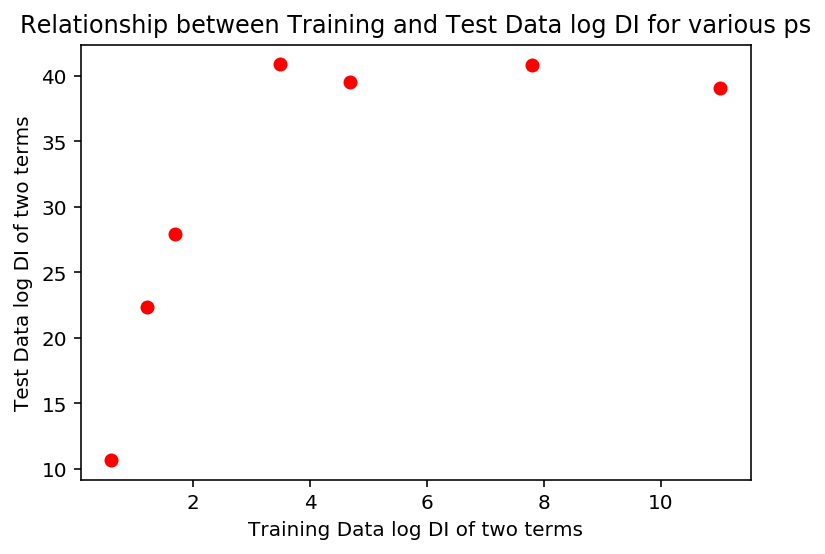

In [11]:
plt.plot(logs_training, logs_test, "ro")
plt.title("Relationship between Training and Test Data log DI for various ps")
plt.xlabel("Training Data log DI of two terms")
plt.ylabel("Test Data log DI of two terms")

In [12]:
for i in range(len(p_vals)):
    p_vals[i] = 1 - p_vals[i]
print(p_vals)

[0.8, 0.7, 0.6, 0.5, 0.4, 0.30000000000000004, 0.19999999999999996]


Text(0,0.5,'log DI of training')

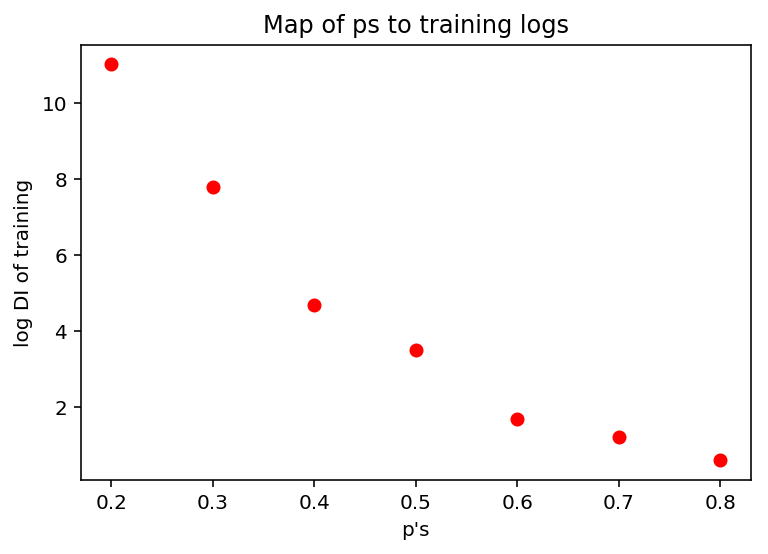

In [13]:
plt.plot(p_vals, logs_training, "ro")
plt.title("Map of ps to training logs")
plt.xlabel("p's")
plt.ylabel("log DI of training")

Text(0,0.5,'log DI of training')

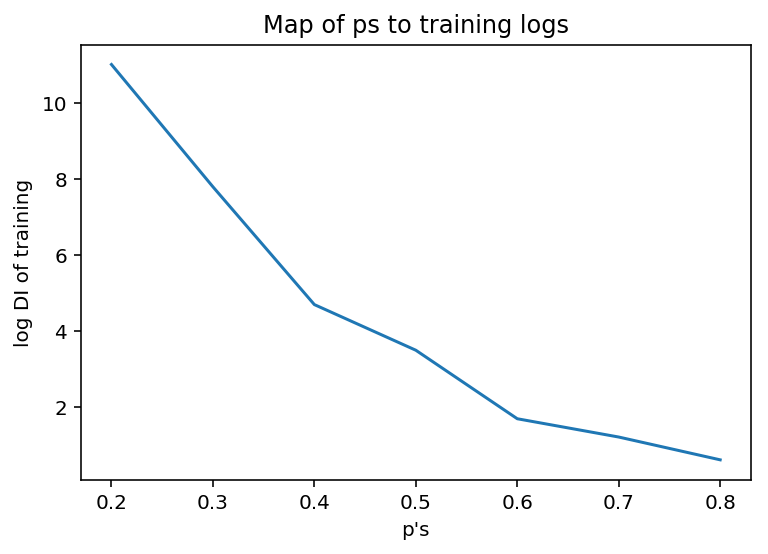

In [14]:
plt.plot(p_vals, logs_training)
plt.title("Map of ps to training logs")
plt.xlabel("p's")
plt.ylabel("log DI of training")

Text(0,0.5,'log DI of test')

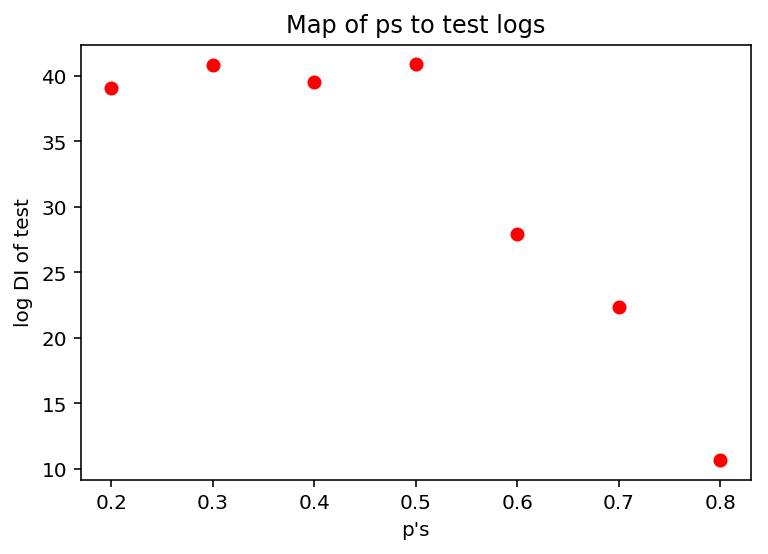

In [15]:
plt.plot(p_vals, logs_test, "ro")
plt.title("Map of ps to test logs")
plt.xlabel("p's")
plt.ylabel("log DI of test")

Text(0,0.5,'log DI of test')

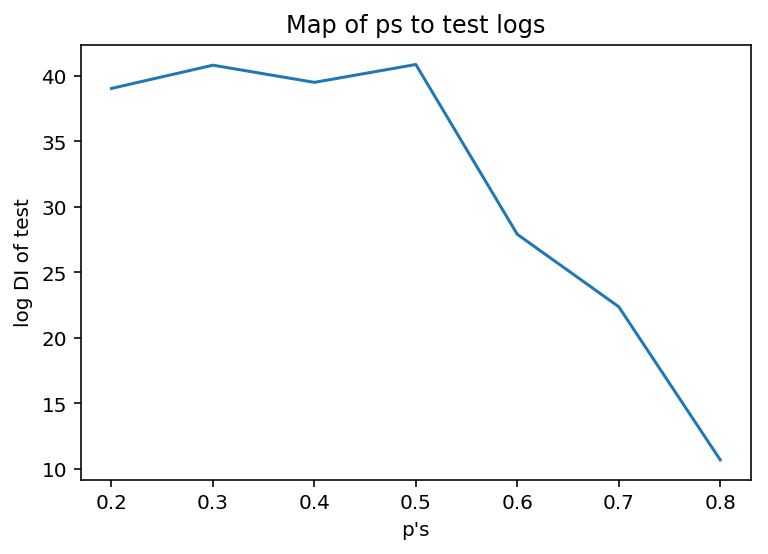

In [16]:
plt.plot(p_vals, logs_test)
plt.title("Map of ps to test logs")
plt.xlabel("p's")
plt.ylabel("log DI of test")

In [17]:
xs_all_logs = []
# print(ys_all_logs)
for i in range(len(ys_all_logs)):
    xs_all_logs.append(ys_all_logs[i])
#print(xs_all_logs)
#print(all_logs_training)

xs_all_logs = np.concatenate(xs_all_logs, axis=None)
#print(xs_all_logs)
#print(len(xs_all_logs))
print(xs_all_logs)
for i in range(len(xs_all_logs)):
    xs_all_logs[i] = 1 - xs_all_logs[i]
print(xs_all_logs)

[0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4 0.4 0.4 0.5 0.5 0.5
 0.5 0.5 0.6 0.6 0.6 0.6 0.6 0.7 0.7 0.7 0.7 0.7 0.8 0.8 0.8 0.8 0.8]
[0.8 0.8 0.8 0.8 0.8 0.7 0.7 0.7 0.7 0.7 0.6 0.6 0.6 0.6 0.6 0.5 0.5 0.5
 0.5 0.5 0.4 0.4 0.4 0.4 0.4 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2]


In [18]:
all_logs_training = np.concatenate(all_logs_training, axis = None)
print(all_logs_training)
print(xs_all_logs)
all_logs_test = np.concatenate(all_logs_test, axis = None)

[ 0.66484356  0.31829352  0.49494774  0.45545206  1.09753469  1.63108054
  1.48253058  0.68420253  1.22860704  1.00409366  2.05166336  1.31842633
  1.47219003  2.16598734  1.42912137  3.24996155  4.1158295   4.0201505
  3.40637067  2.66068985  4.8153891   5.25130032  4.56677998  4.2401703
  4.58393768  7.02185829  7.75901236  9.50520877  7.28296425  7.38833821
 10.30983035 12.50744277  9.74610907 10.68588448 11.80340166]
[0.8 0.8 0.8 0.8 0.8 0.7 0.7 0.7 0.7 0.7 0.6 0.6 0.6 0.6 0.6 0.5 0.5 0.5
 0.5 0.5 0.4 0.4 0.4 0.4 0.4 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2]


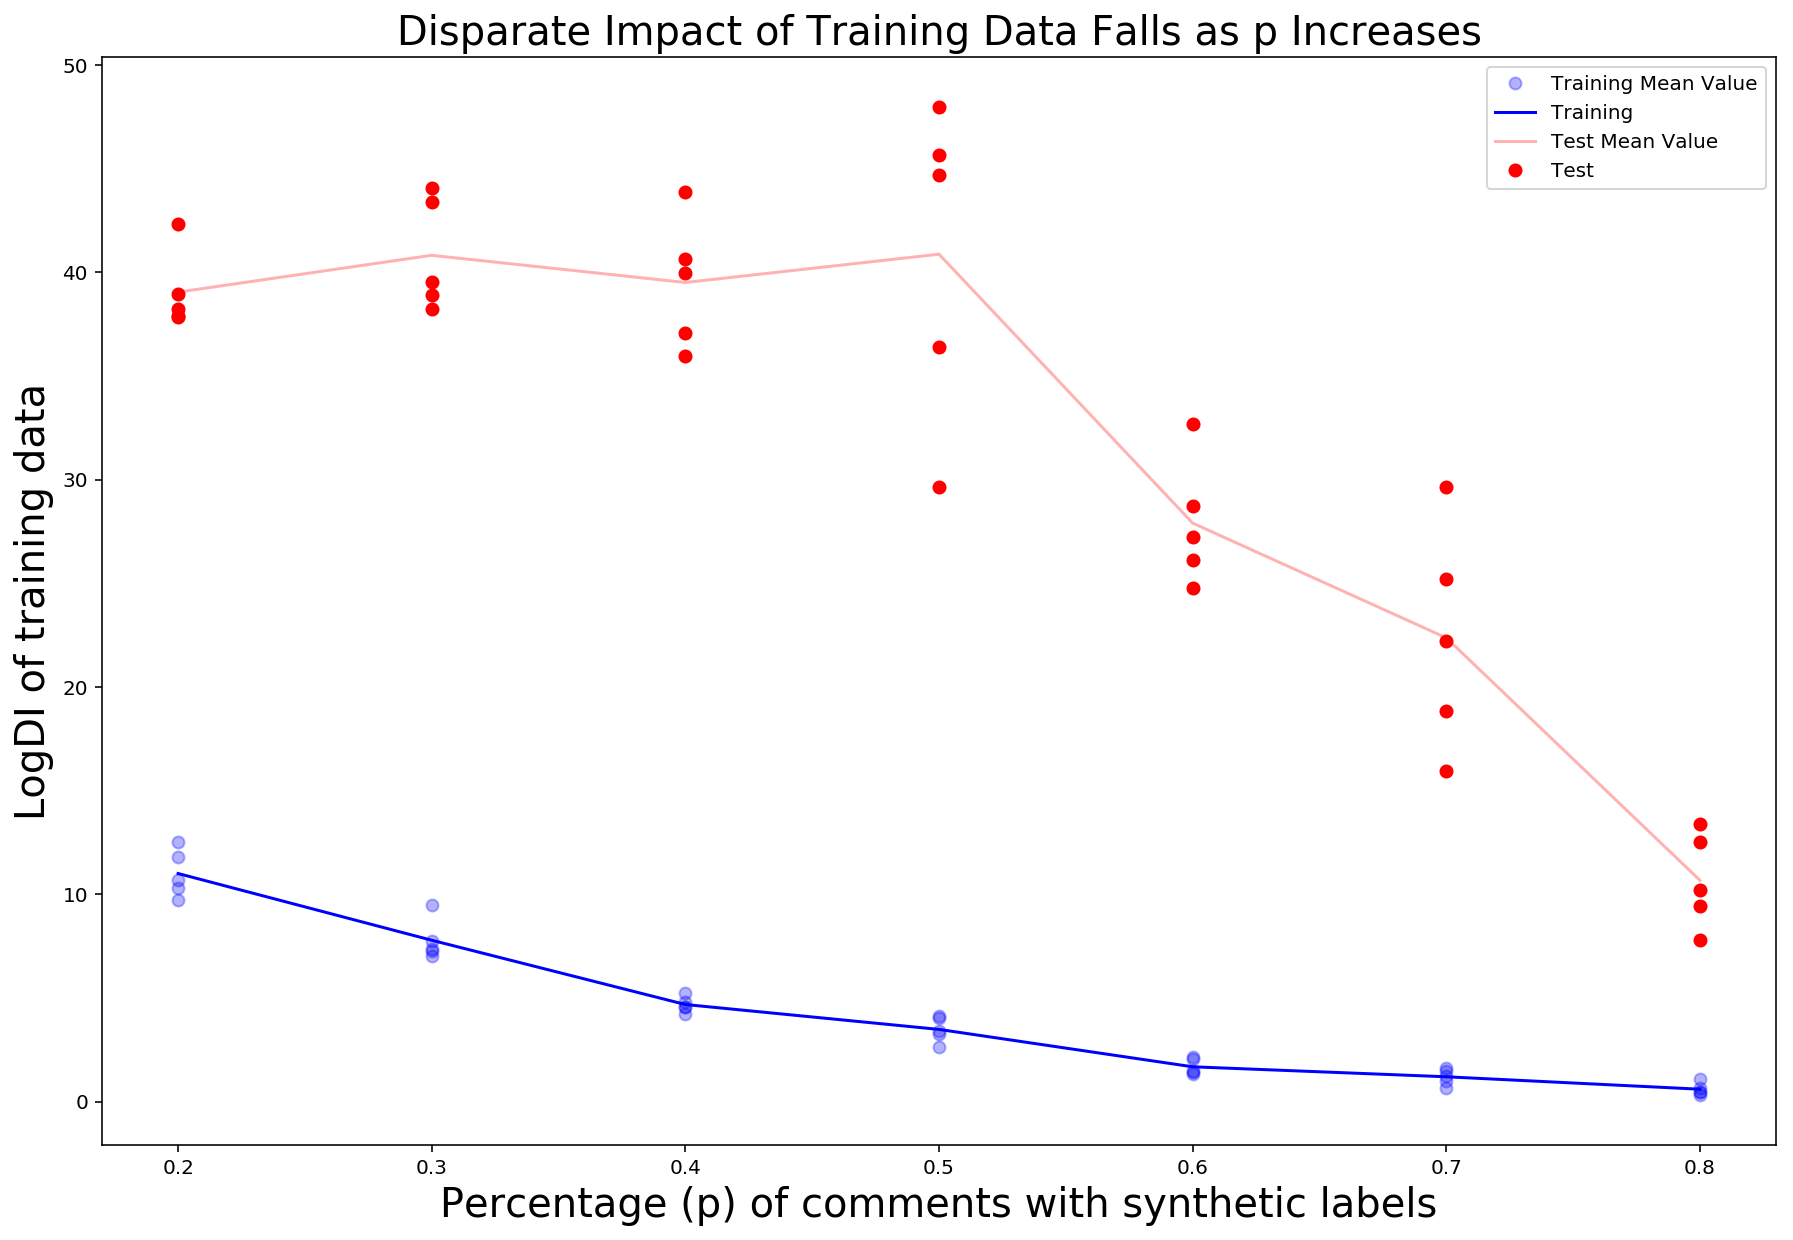

In [40]:
plt.figure(figsize=(15,10))
# blue is training
plt.plot(xs_all_logs, all_logs_training, "bo", alpha = .3, label = "Training Mean Value")
plt.plot(p_vals, logs_training, "blue", label = "Training")

# red will be test
plt.plot(p_vals, logs_test, "red", alpha = .3, label = "Test Mean Value")
plt.plot(xs_all_logs, all_logs_test, "ro", label = "Test")

plt.plot()
plt.title("Disparate Impact of Training Data Falls as p Increases", fontsize=20)
plt.xlabel("Percentage (p) of comments with synthetic labels", fontsize=20)
plt.ylabel("LogDI of training data", fontsize=20)
plt.savefig('DI_tr_data_p_incr.png', bbox_inches='tight')
plt.legend()

In [24]:
# plt.plot(ys_all_logs, all_logs_test)
# plt.title("Map of not-avg ps to test logs")
# plt.xlabel("p's")
# plt.ylabel("log DI of test")

In [ ]:
df_perturbed_training = pd.DataFrame(list_training)
df_perturbed_training = df_perturbed_training.T
df_perturbed_training.columns=p_vals
df_perturbed_training.to_csv("perturbed_training2.csv", index=False)
df_perturbed_test = pd.DataFrame(list_test)
df_perturbed_test = df_perturbed_test.T
df_perturbed_test.columns=p_vals
df_perturbed_training.to_csv("perturbed_test2.csv", index=False)

In [ ]:
df_perturbed_training.head()

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(p_vals, logs_test, "ro", label='test Dataset')
plt.plot(p_vals, logs_training, "o", label='Training Dataset')
plt.legend()